In [1]:
import pandas as pd

data = pd.read_csv('RawData.csv')
data.tail()

,Date,Name,Team,Season,Round,Home Team,Away Team,Home Score,Away Score,Margin,...,Frees For,Frees Against,Contested Pos,Uncontested Pos,Contested Marks,Marks Inside 50,One Percenters,Goal Assists,Brownlow Votes,TOG
146602,2003-03-30 00:00:00,Wayne Carey,Adelaide,2003.0,1,Adelaide,Fremantle,145,89,56,...,1.0,2.0,9.0,4.0,3.0,4.0,4.0,2.0,0.0,85
146603,2003-03-30 00:00:00,Brett Burton,Adelaide,2003.0,1,Adelaide,Fremantle,145,89,56,...,0.0,0.0,9.0,11.0,0.0,0.0,1.0,0.0,0.0,90
146604,2003-03-30 00:00:00,Matthew Bode,Adelaide,2003.0,1,Adelaide,Fremantle,145,89,56,...,1.0,2.0,9.0,12.0,0.0,0.0,1.0,0.0,0.0,96
146605,2003-03-30 00:00:00,Rhett Biglands,Adelaide,2003.0,1,Adelaide,Fremantle,145,89,56,...,1.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,47
146606,2003-03-30 00:00:00,Mark Bickley,Adelaide,2003.0,1,Adelaide,Fremantle,145,89,56,...,1.0,1.0,7.0,10.0,0.0,1.0,0.0,3.0,0.0,61


# Cleaning

In [2]:
games = data.drop_duplicates(subset=['Date', 'Home Team', 'Away Team', 'Margin'])[[
   'Date', 'Season', 'Round', 'Home Team', 'Away Team',
       'Home Score', 'Away Score', 'Margin', 
]]
games

,Date,Season,Round,Home Team,Away Team,Home Score,Away Score,Margin
0,2019-09-28 00:00:00,2019.0,GF,Richmond,Greater Western Sydney,114,25,89
44,2019-09-21 00:00:00,2019.0,PF,Collingwood,Greater Western Sydney,52,56,-4
88,2019-09-20 00:00:00,2019.0,PF,Geelong,Richmond,66,85,-19
132,2019-09-14 00:00:00,2019.0,SF,Brisbane Lions,Greater Western Sydney,80,83,-3
176,2019-09-13 00:00:00,2019.0,SF,Geelong,West Coast,88,68,20
...,...,...,...,...,...,...,...,...
146388,2003-04-26 00:00:00,2003.0,5,Adelaide,Port Adelaide,66,78,-12
146432,2003-04-20 00:00:00,2003.0,4,Adelaide,West Coast,106,73,33
146476,2003-04-13 00:00:00,2003.0,3,Sydney,Adelaide,76,103,-27
146520,2003-04-05 00:00:00,2003.0,2,St Kilda,Adelaide,99,91,8


We have 3333 games in total (what a cool number). 3151 games have Brownlow votes and 182 of them (5.4%) do not. For simplicity I will removed these games

In [3]:
# Number of games with votes
data[data['Brownlow Votes'] == 3].shape[0]

3151

In [4]:
import numpy as np

def preprocess(data=data):
    """
    Extract Year information
    Set GameID=Day+HomeTeam for each game
    Set Win_True and Win_False columns to tell if the player won that game
    Remove if game doesn't have votes
    """
    data['Year'] = data['Date'].str.extract(r"(\d{4})-*")
    data['Year'] = pd.to_numeric(data['Year'])
    
    data['Day'] = data['Date'].str.extract(r"(\d{4}-\d{2}-\d{2})") 
    
    data['GameID'] = data['Day'] + data['Home Team']
            
    data['Win'] = ((data['Team'] == data['Away Team']) & (data['Margin'] < 0))\
        | ((data['Team'] == data['Home Team']) & (data['Margin'] > 0))
    data = pd.get_dummies(data, columns=['Win'])
    
    # games with other than 6 votes (1+2+3) are removed
    games = data.groupby('GameID')['Brownlow Votes'].agg('sum')
    valid_gameIDs = games[np.where(games==6)[0]].index
    data = data[data['GameID'].isin(valid_gameIDs)]
    
    del(data['Day'])
    del(data['Date'])
    return data

In [5]:
clean = preprocess(data)

It shows that for each game, there are 22 players on each side. There is one special case where there are only 21 players in a team, which was Adelaide on 2003-03-30. Could just be a cut-off during scrapping?

In [6]:
for i, g in clean.groupby(['Team', 'GameID']):
    if g.shape[0] != 22:
        print(g.shape[0])
        print(g[['Team', 'GameID']].iloc[0])

21
Team                Adelaide
GameID    2003-03-30Adelaide
Name: 146586, dtype: object


In [7]:
# Splify by removing this game:
clean = clean[clean['GameID'] != '2003-03-30Adelaide']

In [8]:
train = clean[clean['Year'] <= 2015]
test = clean[clean['Year'] > 2015]
del(clean)
del(data)

In [9]:
print(train.shape)
print(test.shape)

(104940, 35)
(33660, 35)


# Exploration

The number of games in `train` is 2333:

In [10]:
games = train.drop_duplicates(subset=['Home Team', 'Away Team', 'Margin'])[[
   'Season', 'Round', 'Home Team', 'Away Team',
       'Home Score', 'Away Score', 'Margin', 
]]
games

,Season,Round,Home Team,Away Team,Home Score,Away Score,Margin
27412,2015.0,16,Gold Coast,Greater Western Sydney,79,94,-15
27456,2015.0,4,Greater Western Sydney,Gold Coast,119,53,66
27500,2014.0,6,Gold Coast,Greater Western Sydney,134,94,40
27544,2013.0,23,Gold Coast,Greater Western Sydney,146,63,83
27588,2013.0,5,Greater Western Sydney,Gold Coast,104,148,-44
...,...,...,...,...,...,...,...
146344,2003.0,6,North Melbourne,Adelaide,70,124,-54
146388,2003.0,5,Adelaide,Port Adelaide,66,78,-12
146432,2003.0,4,Adelaide,West Coast,106,73,33
146476,2003.0,3,Sydney,Adelaide,76,103,-27


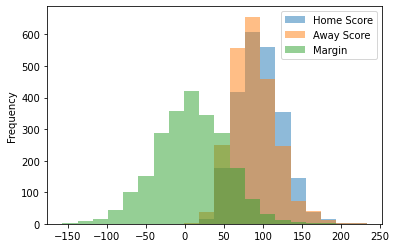

In [11]:
games[['Home Score', 'Away Score', 'Margin']].plot.hist(bins=20, alpha=0.5)

It shows that the Margin's mean is positive, meaning on average Home Score is higher than Away Score. Does this mean Home wins more than Away?

In [12]:
games['Home_won'] = games['Margin'] > 0
games['Home_won'].value_counts()

True     1323
False    1010
Name: Home_won, dtype: int64

The number of Home wins is 1.3 times the number of Away wins.

Next, let's show the distribution of performance indices:

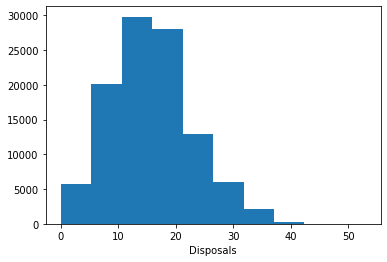

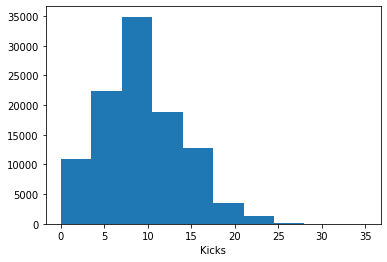

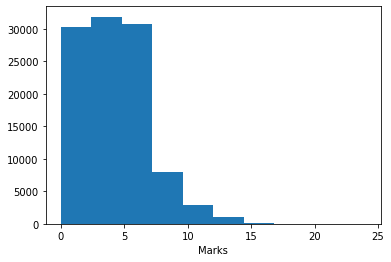

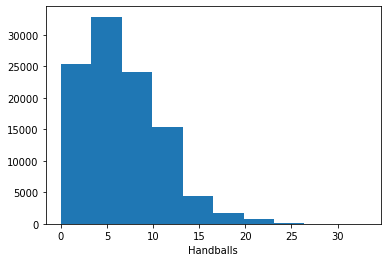

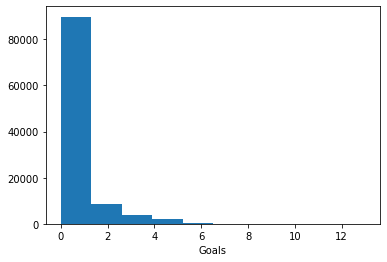

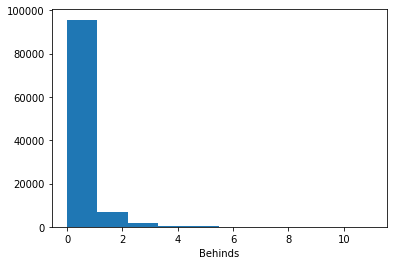

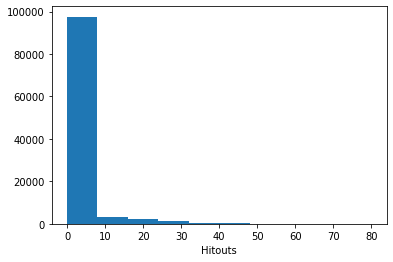

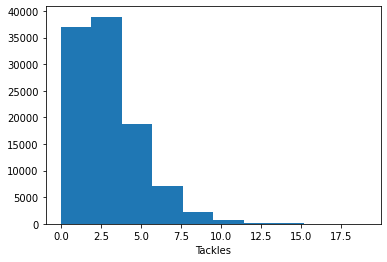

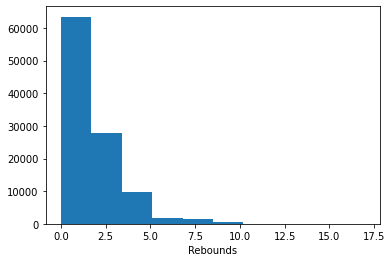

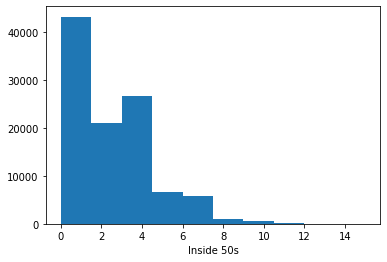

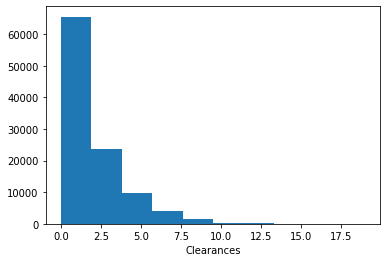

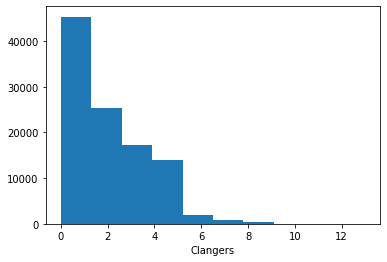

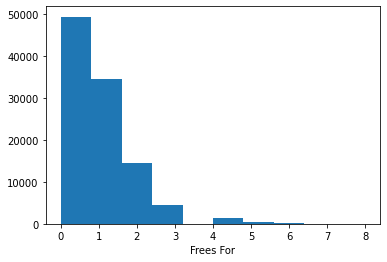

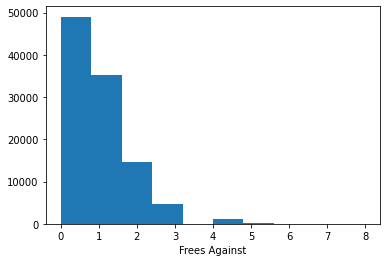

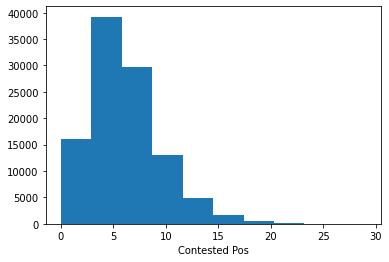

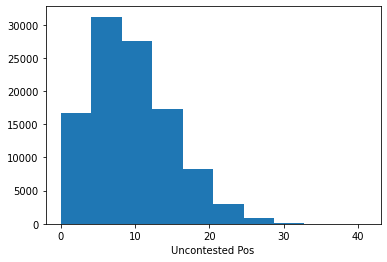

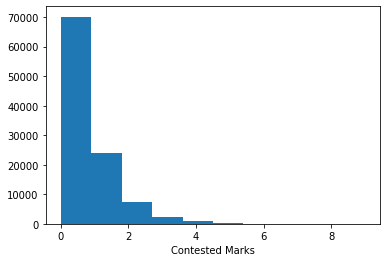

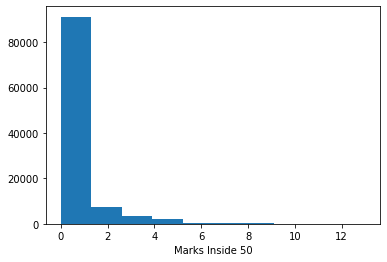

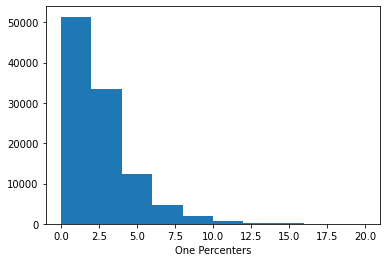

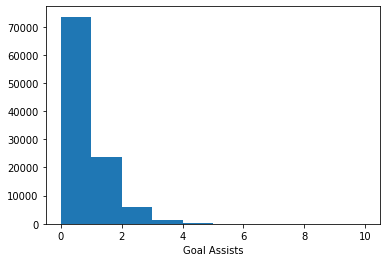

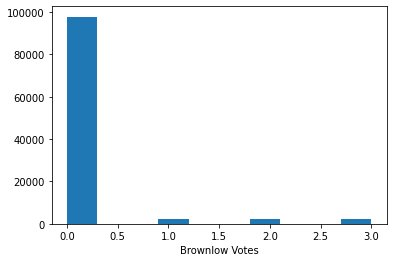

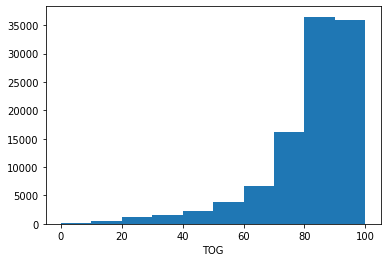

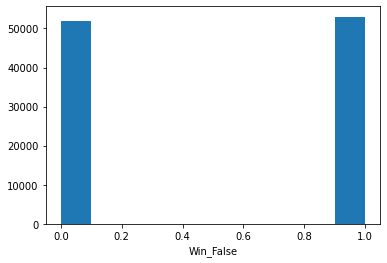

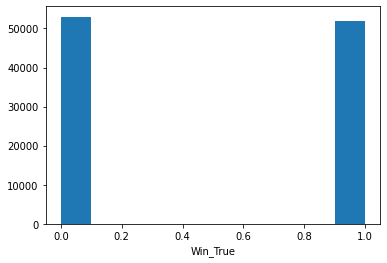

In [13]:
import matplotlib.pyplot as plt


perf_idx = ['Disposals', 'Kicks', 'Marks',
       'Handballs', 'Goals', 'Behinds', 'Hitouts', 'Tackles', 'Rebounds',
       'Inside 50s', 'Clearances', 'Clangers', 'Frees For', 'Frees Against',
       'Contested Pos', 'Uncontested Pos', 'Contested Marks',
       'Marks Inside 50', 'One Percenters', 'Goal Assists', 'Brownlow Votes',
       'TOG', 'Win_False', 'Win_True']

def histogram(data, col):
    fig, ax = plt.subplots()
    ax.hist(data[col])
    ax.set_xlabel(col)
    plt.show()
    
for p in perf_idx:
    histogram(train, p)

We specifically care about the difference between the normal players and the voted ones:

In [14]:
import seaborn as sns
def scatter_by_votes(data, col):
    fig, ax = plt.subplots()
    sns.stripplot(train['Brownlow Votes'], train[col], jitter=0.2, size=2, ax=ax)
    plt.show()

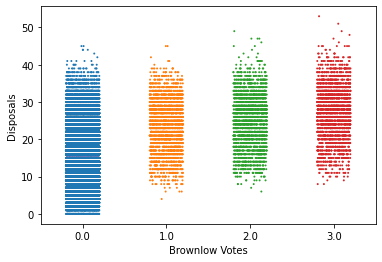

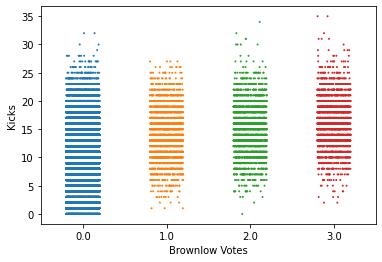

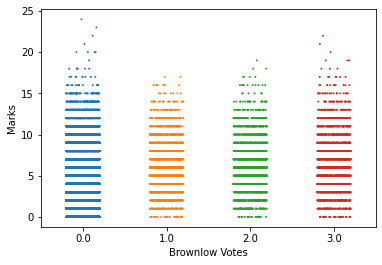

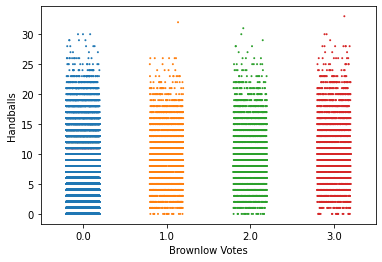

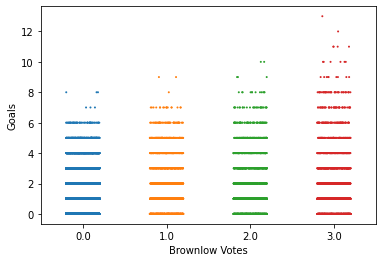

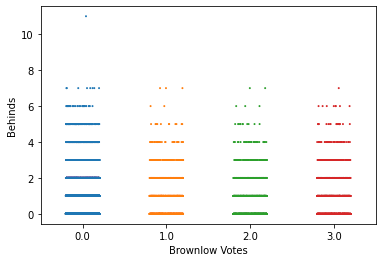

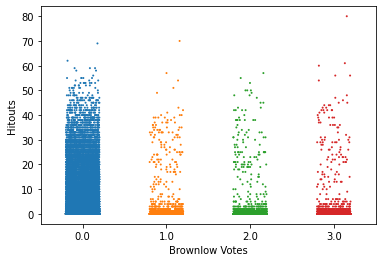

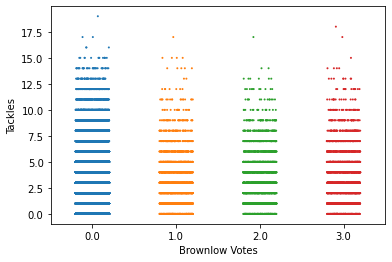

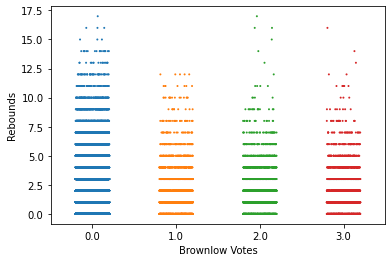

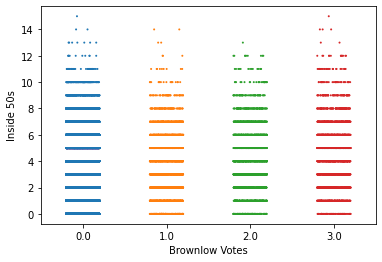

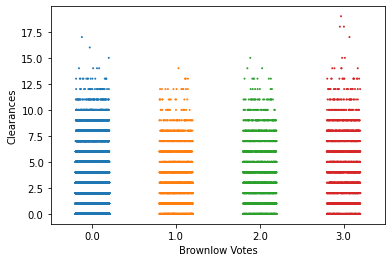

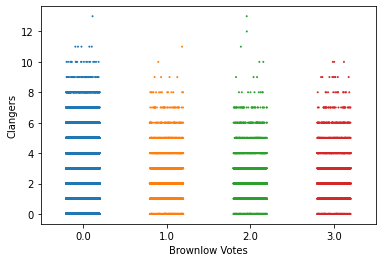

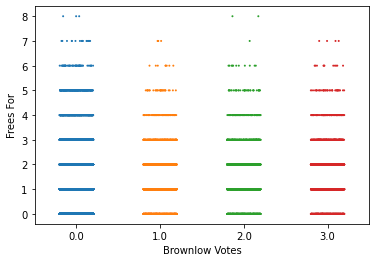

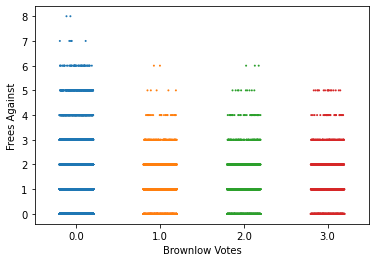

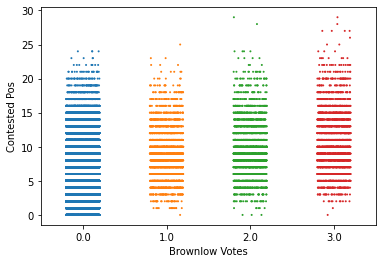

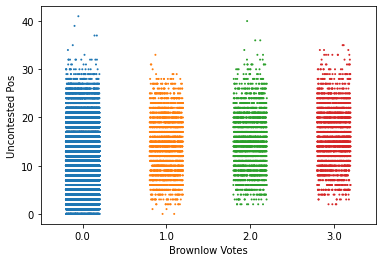

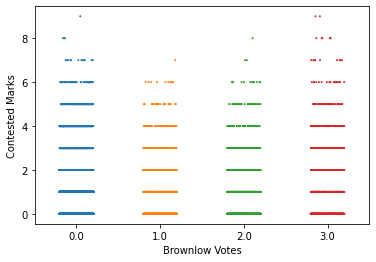

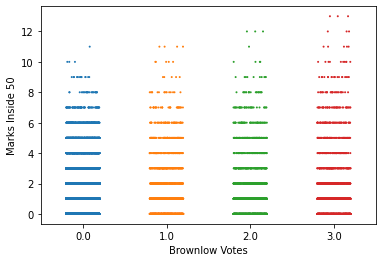

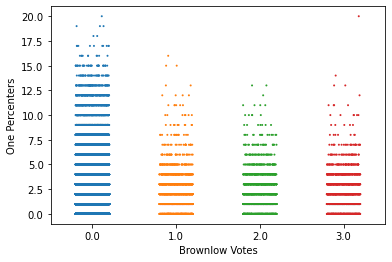

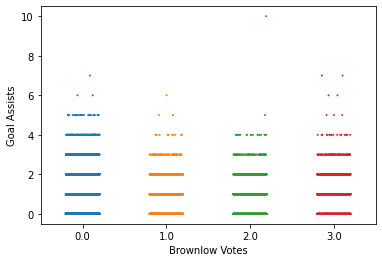

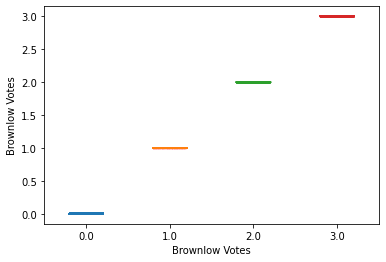

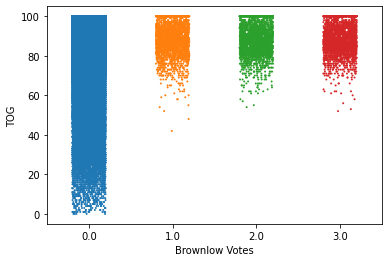

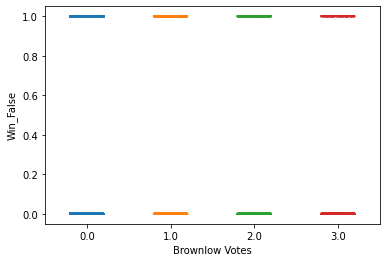

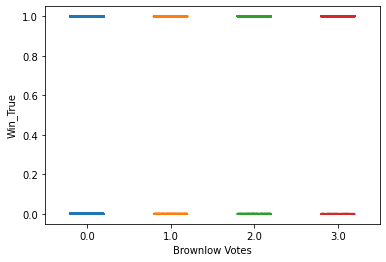

In [15]:
for p in perf_idx:
    scatter_by_votes(train, p)

It shows that some of the most telling indices are: 
- TOG: No voted player plays under 40 minutes
- Goals, Marks inside 50s, Contested Marks, Uncontested Pos, Contested Pos, Inside 50s, Handballs, Kicks, Disposals

We can confirm these with a correlation matrix:

In [16]:
train.columns

Index(['Name', 'Team', 'Season', 'Round', 'Home Team', 'Away Team',
       'Home Score', 'Away Score', 'Margin', 'Disposals', 'Kicks', 'Marks',
       'Handballs', 'Goals', 'Behinds', 'Hitouts', 'Tackles', 'Rebounds',
       'Inside 50s', 'Clearances', 'Clangers', 'Frees For', 'Frees Against',
       'Contested Pos', 'Uncontested Pos', 'Contested Marks',
       'Marks Inside 50', 'One Percenters', 'Goal Assists', 'Brownlow Votes',
       'TOG', 'Year', 'GameID', 'Win_False', 'Win_True'],
      dtype='object')

In [17]:
corr = train[['Disposals', 'Kicks', 'Marks',
       'Handballs', 'Goals', 'Behinds', 'Hitouts', 'Tackles', 'Rebounds',
       'Inside 50s', 'Clearances', 'Clangers', 'Frees For', 'Frees Against',
       'Contested Pos', 'Uncontested Pos', 'Contested Marks',
       'Marks Inside 50', 'One Percenters', 'Goal Assists', 'Brownlow Votes',
       'TOG', 'Win_True']].corr()

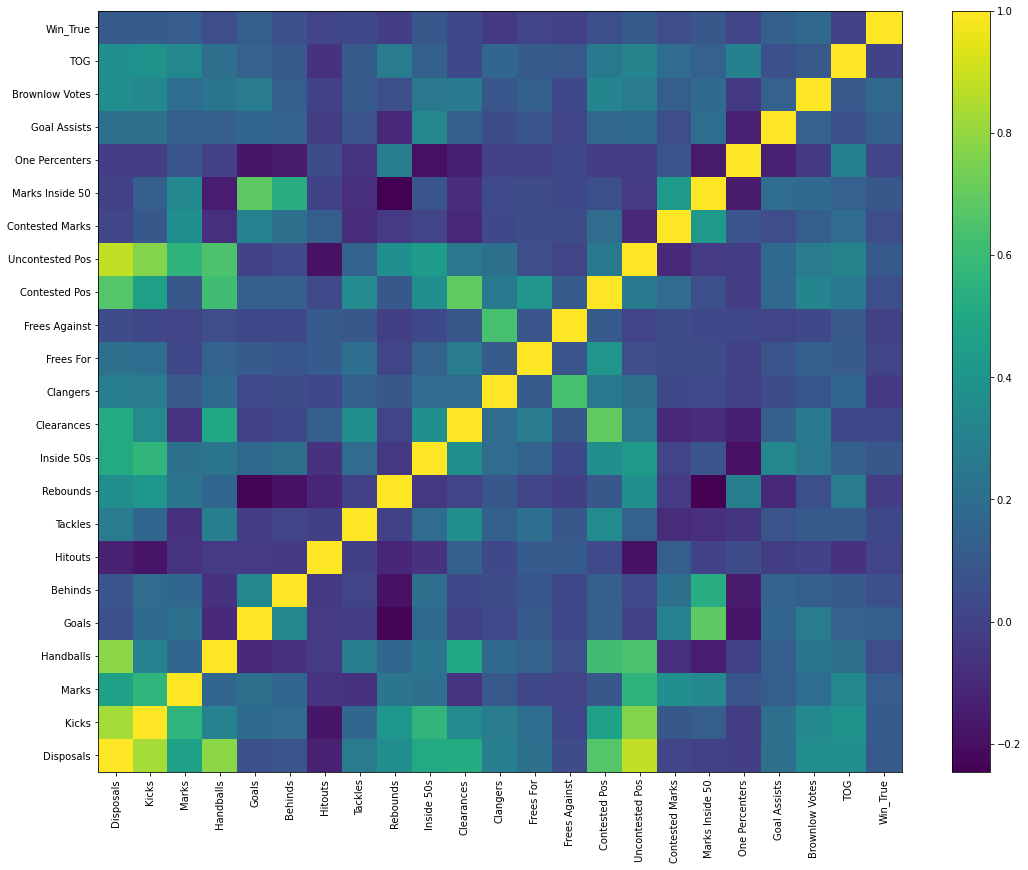

In [18]:
import numpy as np
fig = plt.figure(figsize=(18, 14))
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns, rotation=90)
fig.colorbar(c)

# Approach

It makes more sense to evaluate players in the scope of a game.\
We can make an assumption that players are evaluated according to a certain linear formula of the performance indices, then we can normalize the score using softmax to pick the strongest ones.\
Formally, a training example looks like this:
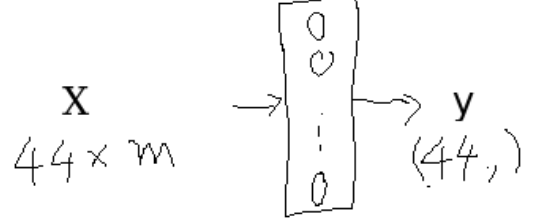

Where each row in $X$ corresponds to a player in that game, and the corresponding entry in $y$ is the number of votes he got.

For simplicity, I use `mse` as the loss function, although it seems that there should be a better one.\
Because I treat this problem as a regression problem, entries in $y$ will be continuous.\
As a final step after the training, I will round these entries to get the final predictions.\
For this problem, because the vote tiers are skewed (more zeros than 1, 2, 3), I choose to evaluate recall percentage for each tier rather than overall accuracy.

In [19]:
features = ['Disposals', 'Kicks', 'Marks',
       'Handballs', 'Goals', 'Behinds', 'Hitouts', 'Tackles', 'Rebounds',
       'Inside 50s', 'Clearances', 'Clangers', 'Frees For', 'Frees Against',
       'Contested Pos', 'Uncontested Pos', 'Contested Marks',
       'Marks Inside 50', 'One Percenters', 'Goal Assists',
       'TOG', 'Win_False', 'Win_True']
n_features = len(features)

BATCH_SIZE = 32
val_split = .3 # Split 30% for validation from train 

In [20]:
import tensorflow as tf

def make_tfds(data, features=features, split=None):
    """
    For each gameID, stack all the players to get a 44xm matrix
    """
            
    data_x, data_y = [],[]
    for i, gameid in enumerate(data['GameID'].unique()):
        game = data[data['GameID']==gameid]
        
        X = np.array(game[features])
        y = np.array(game['Brownlow Votes'])
        
        data_x.append(X)
        data_y.append(y)
        
    data_x = np.asarray(data_x) # shape ?, 44, n_features
    data_y = np.asarray(data_y)
    
    data_x = np.expand_dims(data_x, -1)
    
    if split != None: # create validation set
        split_point = int(split*data_x.shape[0])
        val_x = data_x[:split_point,:,:,:]
        val_y = data_y[:split_point,:]
        train_x = data_x[split_point:,:,:,:] 
        train_y = data_y[split_point:,]
        return tf.data.Dataset.from_tensor_slices((train_x, train_y)), \
                tf.data.Dataset.from_tensor_slices((val_x, val_y))
    
    return tf.data.Dataset.from_tensor_slices((data_x, data_y))

In [21]:
train_dataset, val_dataset = make_tfds(train, features, val_split)
test_dataset = make_tfds(test, features)

In [22]:
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Build and train a model

In [23]:
import tensorflow as tf
print(tf.__version__)
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, \
            Flatten, Conv2D, Dropout, Lambda
from keras.optimizers import SGD, Adam

2.2.0-rc2


In [35]:
def get_model():
    model = Sequential()
    model.add(Conv2D(1, (1, n_features), activation='relu', kernel_initializer='he_uniform', input_shape=(44, n_features, 1)))
    model.add(Conv2D(1, (1, 1), kernel_initializer='he_uniform')),
    model.add(BatchNormalization())
    model.add(Conv2D(1, (1, 1), kernel_initializer='he_uniform')),
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(44))
    return model

Reasons behind this structure:
- Use conv2D to reduce each row in $44\times m$ to a single number representing the overall performance of the player.
- Another conv2D to increase the abstraction level, followed by a Batch Norm to avoid exploding/vanishing gradients.
- Repeat.
- Final dense layer allows indirect communication between nodes in conv2D, which may represents the comparision between them.

In [36]:
model = get_model()

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
              loss='mse')

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 1, 1)          24        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 1, 1)          2         
_________________________________________________________________
batch_normalization (BatchNo (None, 44, 1, 1)          4         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 1, 1)          2         
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 1, 1)          4         
_________________________________________________________________
flatten (Flatten)            (None, 44)                0         
_________________________________________________________________
dense (Dense)                (None, 44)                1

In [39]:
tf.keras.backend.clear_session()

In [40]:
model.evaluate(train_dataset) # loss before training

53/53 [==============================] - 0s 2ms/step - loss: 8055.0547


8055.0546875

In [41]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=200)

Epoch 1/200
53/53 [==============================] - 0s 3ms/step - loss: 1.1038 - val_loss: 22.3363
Epoch 2/200
53/53 [==============================] - 0s 3ms/step - loss: 0.7878 - val_loss: 3.6446
Epoch 3/200
53/53 [==============================] - 0s 3ms/step - loss: 0.6007 - val_loss: 1.2573
Epoch 4/200
53/53 [==============================] - 0s 3ms/step - loss: 0.4865 - val_loss: 0.6997
Epoch 5/200
53/53 [==============================] - 0s 3ms/step - loss: 0.4153 - val_loss: 0.5098
Epoch 6/200
53/53 [==============================] - 0s 3ms/step - loss: 0.3701 - val_loss: 0.4272
Epoch 7/200
53/53 [==============================] - 0s 3ms/step - loss: 0.3409 - val_loss: 0.3833
Epoch 8/200
53/53 [==============================] - 0s 3ms/step - loss: 0.3219 - val_loss: 0.3568
Epoch 9/200
53/53 [==============================] - 0s 3ms/step - loss: 0.3092 - val_loss: 0.3389
Epoch 10/200
53/53 [==============================] - 0s 3ms/step - loss: 0.3005 - val_loss: 0.3248
Epoch 11

53/53 [==============================] - 0s 3ms/step - loss: 0.1766 - val_loss: 0.1864
Epoch 84/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1764 - val_loss: 0.1863
Epoch 85/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1763 - val_loss: 0.1861
Epoch 86/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1761 - val_loss: 0.1860
Epoch 87/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1760 - val_loss: 0.1858
Epoch 88/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1759 - val_loss: 0.1857
Epoch 89/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1757 - val_loss: 0.1855
Epoch 90/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1756 - val_loss: 0.1854
Epoch 91/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1755 - val_loss: 0.1853
Epoch 92/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1753 - val_loss: 0.1851
Epoch 93/200


53/53 [==============================] - 0s 3ms/step - loss: 0.1703 - val_loss: 0.1795
Epoch 165/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1703 - val_loss: 0.1795
Epoch 166/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1703 - val_loss: 0.1795
Epoch 167/200
53/53 [==============================] - 0s 2ms/step - loss: 0.1703 - val_loss: 0.1795
Epoch 168/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1703 - val_loss: 0.1795
Epoch 169/200
53/53 [==============================] - 0s 2ms/step - loss: 0.1703 - val_loss: 0.1800
Epoch 170/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1703 - val_loss: 0.1798
Epoch 171/200
53/53 [==============================] - 0s 2ms/step - loss: 0.1703 - val_loss: 0.1799
Epoch 172/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1703 - val_loss: 0.1798
Epoch 173/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1703 - val_loss: 0.1799
Epoc

In [46]:
import matplotlib.pyplot as plt

def summarize_diagnostics(history):
    # plot log of loss
    plt.plot(np.log(history.history['loss']), color='blue', label='train')
    plt.plot(np.log(history.history['val_loss']), color='orange', label='val')
    # plot accuracy
    plt.legend()
    plt.show()

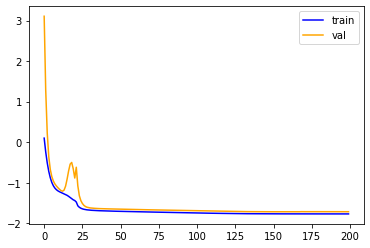

In [47]:
summarize_diagnostics(history)

In [44]:
# Performance on val
pred = model.predict(val_dataset)

pred = pred.flatten()

truth = np.array(train['Brownlow Votes'])

def custom_eval(pred, true):
    
    count = {'1':0, '2':0, '3':0, '0':0}
    total = {'1':0, '2':0, '3':0, '0':0}
    
    for p,t in zip(list(pred), list(truth)):
        total[str(int(t))] += 1
        if round(p) == t:
            count[str(int(t))] += 1
            
    return [count[i]/total[i]*100 for i in ('1','2','3','0')]
                  
custom_eval(pred, truth)

[51.048951048951054, 16.223776223776223, 7.4125874125874125, 94.64438001023366]

In [45]:
# Performance on test
pred = model.predict(test_dataset)
pred = pred.flatten()

truth = np.array(test['Brownlow Votes'])

custom_eval(pred, truth)

[55.294117647058826, 24.313725490196077, 8.49673202614379, 93.53419416547106]

Summary performance on Test set:
- Recall for `Brownlow=0` entries is 93.5%
- Recall for `1` entries is 55.3%
- Recall for `2` entries is 24.3%
- Recall for `3` entries is 8.5%

# Space for improvement and experiment
This problem is close to pixel level classification in computer vision, where we feed an image (a matrix) and obtain a matrix of the same dimension with each entry is the class for the corresponding pixel in the original matrix. We can take a look at that problem to see what kind of loss they use.\
As far as I know, they often use binary masks in such problems. This may lead to complication.\
Another approach is to use a different model.